In [1]:
! rm -rf ./models && git clone https://github.com/tensorflow/models.git \
    && sed -i "s#ImageFont.truetype('arial.ttf', 24)#ImageFont.truetype('arial.ttf', 50)#g" ./models/research/object_detection/utils/visualization_utils.py \
    && cp /usr/share/fonts/truetype/dejavu/DejaVuSans.ttf /usr/share/fonts/truetype/dejavu/arial.ttf

Cloning into 'models'...
remote: Enumerating objects: 81105, done.
remote: Counting objects: 100% (642/642), done.
remote: Compressing objects: 100% (311/311), done.
remote: Total 81105 (delta 406), reused 537 (delta 328), pack-reused 80463
Receiving objects: 100% (81105/81105), 596.10 MiB | 32.17 MiB/s, done.
Resolving deltas: 100% (57735/57735), done.


In [2]:
! cd models/research \
    && protoc object_detection/protos/*.proto --python_out=. \
    && cp object_detection/packages/tf2/setup.py . && \
    python3 -m pip install --use-feature=2020-resolver .

Processing /kaggle/working/models/research
  Preparing metadata (setup.py) ... - \ done
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 352.1/352.1 kB 1.7 MB/s eta 0:00:00
  Installing build dependencies ... - \ | / - \ | / - \ done
  Getting requirements to build wheel ... - done
  Preparing metadata (pyproject.toml) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.6/116.6 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.9/238.9 kB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 636.6/636.6 kB 36.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 29.1 MB/s e

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image
from matplotlib import pyplot as plt
from tensorflow.python.util import compat

from google.protobuf import text_format
import pprint
import json
import os


2023-02-06 18:34:35.340493: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-06 18:34:35.518940: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:
2023-02-06 18:34:35.518979: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-06 18:34:36.867629: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

In [4]:
!pip install --upgrade protobuf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.8/409.8 kB 1.4 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.19.4
    Uninstalling protobuf-3.19.4:
      Successfully uninstalled protobuf-3.19.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
beatrix-jupyterlab 3.1.7 requires google-cloud-bigquery-storage, which is not installed.
wandb 0.12.21 requires protobuf<4.0dev,>=3.12.0, but you have protobuf 4.21.12 which is incompatible.
tfx-bsl 1.9.0 requires google-api-python-client<2,>=1.7.11, but you have google-api-python-client 2.52.0 which is incompatible.
tfx-bsl 1.9.0 requires protobuf<3.21,>=3.13, but you have protobuf 4.21.12 which is incompatible.
tfx-bsl 1.9.0 requires pyarrow<6,>=1, but you have pyarrow 7.0.0 which is incompatible.
tensorflow 2.11.0 requires protobuf<3.20,>=3.9.2, but you have protobuf 4.21

In [5]:
from tensorflow.core.protobuf import saved_model_pb2

In [6]:
from object_detection.utils import visualization_utils as vis_util
from object_detection.utils import dataset_util, label_map_util
from object_detection.protos import string_int_label_map_pb2

In [7]:
def reconstruct(pb_path):
    if not os.path.isfile(pb_path):
        print("Error: %s not found" % pb_path)

    print("Reconstructing Tensorflow model")
    detection_graph = tf.Graph()
    with detection_graph.as_default():
        od_graph_def = tf.compat.v1.GraphDef()
        with tf.io.gfile.GFile(pb_path, 'rb') as fid:
            serialized_graph = fid.read()
            od_graph_def.ParseFromString(serialized_graph)
            tf.import_graph_def(od_graph_def, name='')
    print("Success!")
    return detection_graph

In [8]:
def image2np(image):
    (w, h) = image.size
    return np.array(image.getdata()).reshape((h, w, 3)).astype(np.uint8)

def image2tensor(image):
    npim = image2np(image)
    return np.expand_dims(npim, axis=0)

%matplotlib inline
def detect(detection_graph, test_image_path):
    with detection_graph.as_default():
        gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.01)
        with tf.compat.v1.Session(graph=detection_graph,config=tf.compat.v1.ConfigProto(gpu_options=gpu_options)) as sess:
            image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
            detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
            detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
            detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
            num_detections = detection_graph.get_tensor_by_name('num_detections:0')

            image = Image.open(test_image_path)
            (boxes, scores, classes, num) = sess.run(
                [detection_boxes, detection_scores, detection_classes, num_detections],
                feed_dict={image_tensor: image2tensor(image)}
            )

            npim = image2np(image)
            vis_util.visualize_boxes_and_labels_on_image_array(
                npim,
                np.squeeze(boxes),
                np.squeeze(classes).astype(np.int32),
                np.squeeze(scores),
                category_index,
                use_normalized_coordinates=True,
                line_thickness=15)
            plt.figure(figsize=(12, 8))
            plt.imshow(npim)
            plt.show()

In [9]:
import os
DATA_DIR = '/kaggle/input/tacotrashdataset/data'
ANNOTATIONS_FILE = os.path.join(DATA_DIR, 'annotations.json')
NCLASSES = 60

In [10]:
import json
with open(ANNOTATIONS_FILE) as json_file:
    data = json.load(json_file)
    
categories = data['categories']

In [11]:
print('Building label map from examples')

labelmap = string_int_label_map_pb2.StringIntLabelMap()
for idx,category in enumerate(categories):
    item = labelmap.item.add()
    # label map id 0 is reserved for the background label
    item.id = int(category['id'])+1
    item.name = category['name']

with open('./labelmap.pbtxt', 'w') as f:
    f.write(text_format.MessageToString(labelmap))

print('Label map witten to labelmap.pbtxt')

with open('./labelmap.pbtxt') as f:
    pprint.pprint(f.readlines())

Building label map from examples
Label map witten to labelmap.pbtxt
['item {\n',
 '  name: "Aluminium foil"\n',
 '  id: 1\n',
 '}\n',
 'item {\n',
 '  name: "Battery"\n',
 '  id: 2\n',
 '}\n',
 'item {\n',
 '  name: "Aluminium blister pack"\n',
 '  id: 3\n',
 '}\n',
 'item {\n',
 '  name: "Carded blister pack"\n',
 '  id: 4\n',
 '}\n',
 'item {\n',
 '  name: "Other plastic bottle"\n',
 '  id: 5\n',
 '}\n',
 'item {\n',
 '  name: "Clear plastic bottle"\n',
 '  id: 6\n',
 '}\n',
 'item {\n',
 '  name: "Glass bottle"\n',
 '  id: 7\n',
 '}\n',
 'item {\n',
 '  name: "Plastic bottle cap"\n',
 '  id: 8\n',
 '}\n',
 'item {\n',
 '  name: "Metal bottle cap"\n',
 '  id: 9\n',
 '}\n',
 'item {\n',
 '  name: "Broken glass"\n',
 '  id: 10\n',
 '}\n',
 'item {\n',
 '  name: "Food Can"\n',
 '  id: 11\n',
 '}\n',
 'item {\n',
 '  name: "Aerosol"\n',
 '  id: 12\n',
 '}\n',
 'item {\n',
 '  name: "Drink can"\n',
 '  id: 13\n',
 '}\n',
 'item {\n',
 '  name: "Toilet tube"\n',
 '  id: 14\n',
 '}\n',
 'it

In [12]:
label_map = label_map_util.load_labelmap('labelmap.pbtxt')
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NCLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

In [13]:
detection_graph = reconstruct("../input/trained-models-taco-trash-annotations-in-context/ssd_mobilenet_v2_taco_2018_03_29.pb")

Reconstructing Tensorflow model
Success!


2023-02-06 18:35:07.251773: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-06 18:35:07.252995: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:
2023-02-06 18:35:07.253047: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-06 18:35:07.253088: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on t

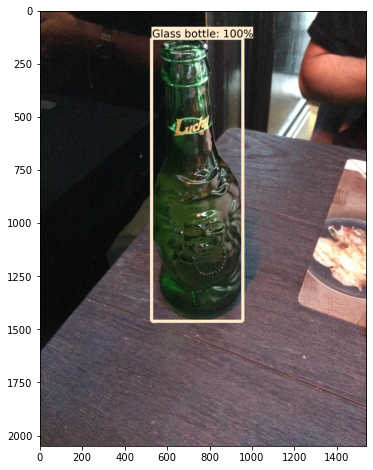

In [14]:
detect(detection_graph, '/kaggle/input/tacotrashdataset/data/batch_1/000006.jpg')

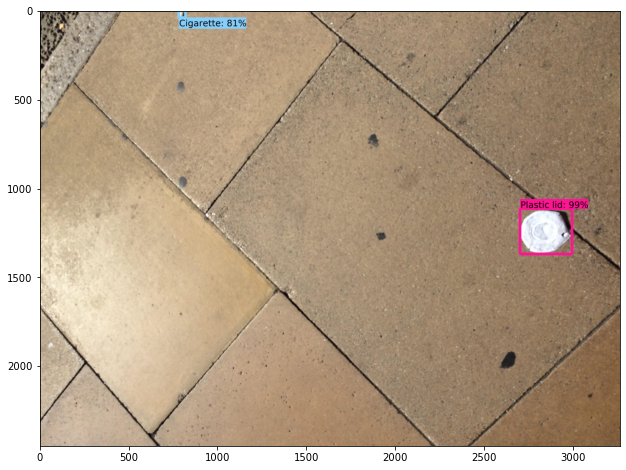

In [15]:
detect(detection_graph, '/kaggle/input/tacotrashdataset/data/batch_3/IMG_4852.JPG')

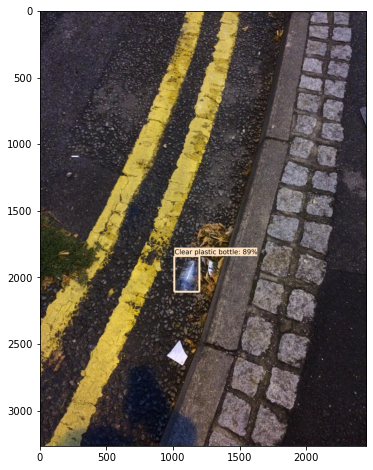

In [16]:
detect(detection_graph, '/kaggle/input/tacotrashdataset/data/batch_5/000000.JPG')

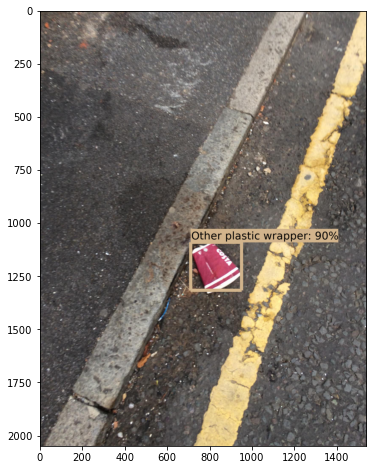

In [17]:
detect(detection_graph, '/kaggle/input/tacotrashdataset/data/batch_1/000003.jpg')

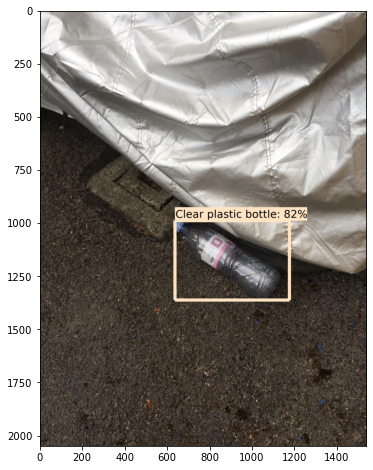

In [18]:
detect(detection_graph, '/kaggle/input/tacotrashdataset/data/batch_1/000010.jpg')